# Test Fldzhyan imbalance problem

Prooblem that Fldzhyan architecture is not simmetrical to the imb strange

This measumetn has n=8 seed=37 and iloss=0.4. Not relevant just show the problem

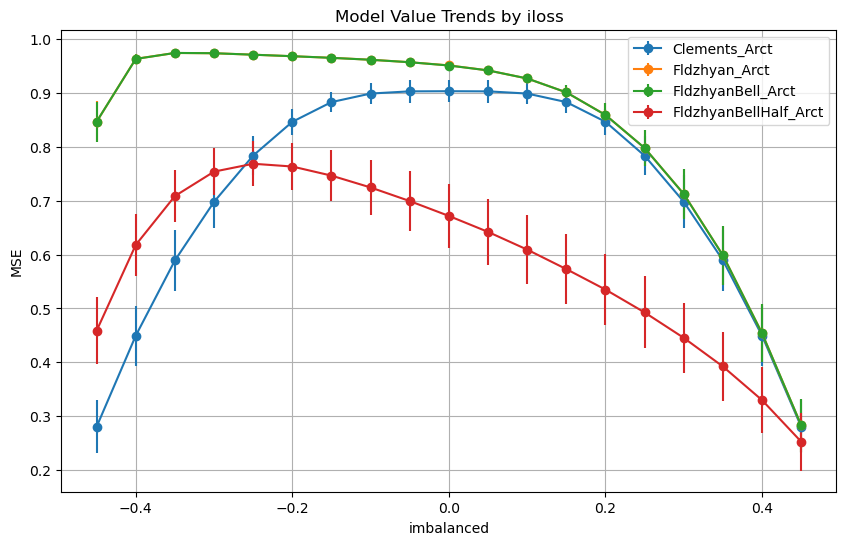

Clements_Arct average imb=0.0: 0.9034679168721675
Fldzhyan_Arct average imb=0.0: 0.9514376888893441
FldzhyanBell_Arct average imb=0.0: 0.9512108758222098
FldzhyanBellHalf_Arct average imb=0.0: 0.6718181758890116


In [6]:
# Create the grapth
import json
import matplotlib.pyplot as plt

JSON_file_name = 'organized_data/20240612_traking_N8_Fidelity_sweep_iloss_imb.json'

name_models_choise = [
    'Clements_Arct',
    'Fldzhyan_Arct', 'FldzhyanBell_Arct',
    'FldzhyanBellHalf_Arct',]

# Download the file
with open(JSON_file_name, 'r') as file:
    data = json.load(file)
simulations = data["simulations"]

def filter_list_of_dicts(dict_list, name_arch):
    filtered_list = []
    for dictionary in dict_list:
        for value in dictionary.values():
            if value == name_arch:
                filtered_list.append(dictionary)
                break  # No need to check other values in the same dictionary
    return filtered_list

plt.figure(figsize=(10, 6))
for name_arch in name_models_choise:
    filtered_list_disct = filter_list_of_dicts(simulations, name_arch)
    imbalances = [sim["imbalance_const"] for sim in filtered_list_disct]
    average = [sim["average"] for sim in filtered_list_disct]
    std_dev = [sim["std_dev"] for sim in filtered_list_disct]
    plt.errorbar(imbalances, average, yerr=std_dev,
                marker='o', label=name_arch)
plt.title('Model Value Trends by iloss')
plt.xlabel('imbalanced')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

for model in name_models_choise:
    idx = 9
    MSE_0 = [sim["average"] for sim in filter_list_of_dicts(simulations, model)][idx]
    imb = [sim["imbalance_const"] for sim in filter_list_of_dicts(simulations, model)][idx]
    print(model+' average imb='+str(imb)+': '+str(MSE_0))

In [24]:
# Fidelity Data analysis

# import stuff
import os
import numpy as np
import re
import pandas as pd

# extract data of one simulation
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples

# derive Fidelity for the one simulation
# Compute Fidelity Unitary
def FidelityUnitary(target_matrix, predicted_matrix):
    target_matrix = np.array(target_matrix, dtype=np.complex128)
    predicted_matrix = np.array(predicted_matrix, dtype=np.complex128)
    trace_pH_p = np.trace(np.dot(predicted_matrix.conj().T, predicted_matrix)).real    # result is REAL
    trace_pH_t = np.trace(np.dot(predicted_matrix.conj().T, target_matrix))
    cosine_similarity = np.abs(trace_pH_t)**2/(target_matrix.shape[0]*trace_pH_p)
    return cosine_similarity

def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

def derive_Fidelity_1sim(target_tuples, predit_tuples):
    loss = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            loss.extend([FidelityUnitary(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    labels = [t[0] for t in predit_tuples]
    loss_pd = pd.DataFrame({'label': labels, 'value': loss})
    return loss_pd

# take max value and derive average and std dev
def models_repmax_mean_devstd(df, name_models, simulation_folder):
    # Extracting the base label (e.g., 'LabelA', 'LabelB')
    df['label_no_rep'] = df['label'].apply(lambda x: x.split('_rep')[0])
    # Group with the base label and find max
    max_lastLoss_s = df.groupby('label_no_rep')['value'].max()

    averages = []
    std_devs = []
    for name in name_models:
        # model_s take the all 1000 sim same model with the best repetition value
        model_s = max_lastLoss_s[max_lastLoss_s.index.str.contains(name)]
        averages.append(model_s.mean())
        std_devs.append(model_s.std())
    
    # Extract and convert to float
    iloss_match = re.search(r"iloss(-?\d+\.\d+)", simulation_folder)
    imb_match = re.search(r"imb(-?\d+\.\d+)", simulation_folder)
    iloss = float(iloss_match.group(1)) if iloss_match else None
    imb = float(imb_match.group(1)) if imb_match else None
    ave_std_dev_pd = pd.DataFrame({'simulation':simulation_folder, 'name_model': name_models,
                                   'average': averages, 'std_dev': std_devs,
                                   'iloss': iloss, 'imb': imb,})
    return ave_std_dev_pd


# =================================================================================================================
# MAIN
# =================================================================================================================
directory_run = 'outdata/20240617_testFldzhyan_imb'
seed = 100
name_models = [
    'Fldzhyan_Arct',]

data_df = pd.DataFrame()
for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if "seed"+str(seed) in directory_path:     # take the seed I wanted
        if not os.path.isfile(directory_path):
            target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
            mse_pd = derive_Fidelity_1sim(target_tuples, predit_tuples)
            simulation_folder = os.path.basename(directory_path)
            ave_std_dev_pd = models_repmax_mean_devstd(mse_pd, name_models, simulation_folder)
            data_df = pd.concat([data_df, ave_std_dev_pd], ignore_index=True)

data_df

,simulation,name_model,average,std_dev,iloss,imb
0,seed100_n4_iloss0.0_imb-0.2_crosstalk0.0_HPC_s...,Fldzhyan_Arct,0.997877,0.005616,0.0,-0.2
1,seed100_n4_iloss0.0_imb0.0_crosstalk0.0_HPC_si...,Fldzhyan_Arct,0.998069,0.006818,0.0,0.0
2,seed100_n4_iloss0.0_imb0.2_crosstalk0.0_HPC_si...,Fldzhyan_Arct,0.987958,0.021420,0.0,0.2


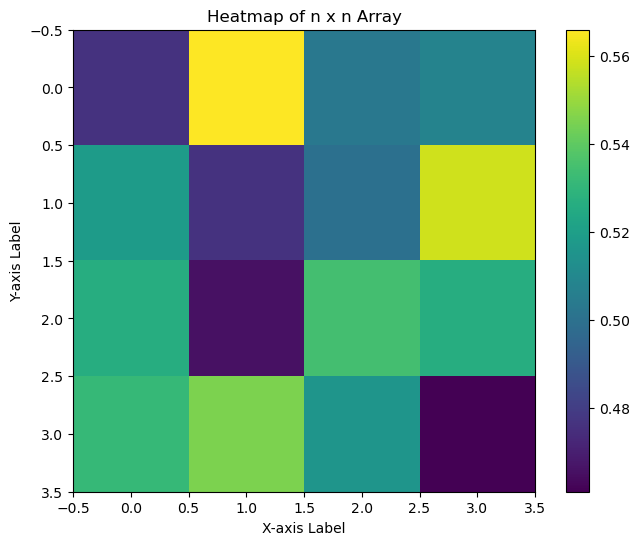

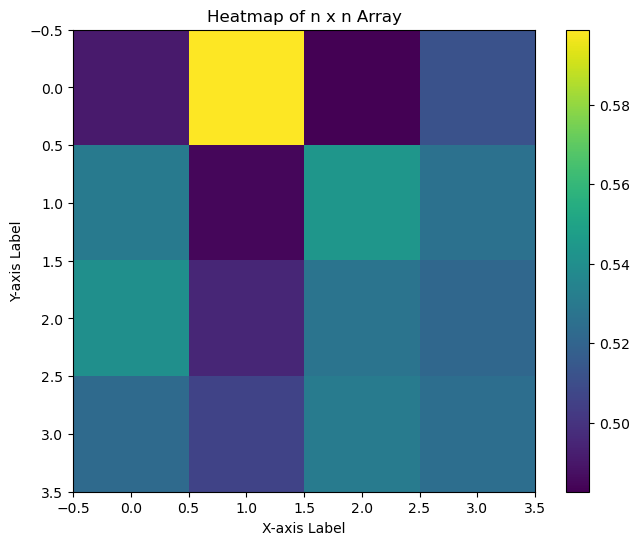

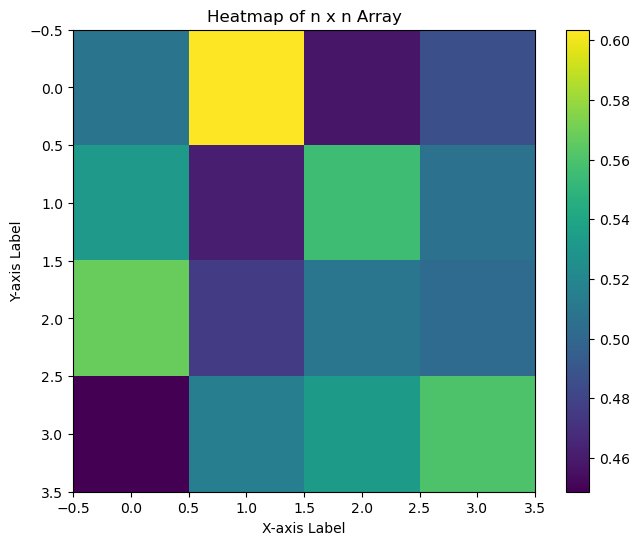

In [25]:
# Fidelity Data analysis

# import stuff
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# extract data of one simulation
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples

# derive Fidelity for the one simulation
# Compute Fidelity Unitary
def FidelityUnitary(target_matrix, predicted_matrix):
    target_matrix = np.array(target_matrix, dtype=np.complex128)
    predicted_matrix = np.array(predicted_matrix, dtype=np.complex128)
    trace_pH_p = np.trace(np.dot(predicted_matrix.conj().T, predicted_matrix)).real    # result is REAL
    trace_pH_t = np.trace(np.dot(predicted_matrix.conj().T, target_matrix))
    cosine_similarity = np.abs(trace_pH_t)**2/(target_matrix.shape[0]*trace_pH_p)
    return cosine_similarity

def FidelityUnitary_1element(target_matrix, predicted_matrix):
    n, n = target_matrix.shape
    target_matrix = np.array(target_matrix, dtype=np.complex128)
    predicted_matrix = np.array(predicted_matrix, dtype=np.complex128)
    fidelity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            target_value = target_matrix[i, j]
            predicted_value = predicted_matrix[i, j]
            trace_pH_p = np.dot(predicted_value.conj().T, predicted_value).real    # result is REAL
            trace_pH_t = np.dot(predicted_value.conj().T, target_value)
            fidelity_matrix[i, j] = np.abs(trace_pH_t)**2/trace_pH_p
    return fidelity_matrix

# Compute MSE
def CMatrixMSELoss(target_matrix, predicted_matrix):
    n, n = target_matrix.shape
    target_matrix = np.array(target_matrix, dtype=np.complex128)
    predicted_matrix = np.array(predicted_matrix, dtype=np.complex128)
    mse_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            target_value = target_matrix[i, j]
            predicted_value = predicted_matrix[i, j]
            mag_diff_sq = np.abs(predicted_value - target_value)**2
            mse_matrix[i, j] = np.sum(mag_diff_sq) / np.size(target_value)
    return mse_matrix

def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

# def derive_Fidelity_1sim(target_tuples, predit_tuples):
#     loss = []
#     for i in range(len(target_tuples)):
#         if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
#             loss.extend([FidelityUnitary(target_tuples[i][1], predit_tuples[i][1])])
#         else:
#             print("Capo abbiamo un problema :(")
#     labels = [t[0] for t in predit_tuples]
#     loss_pd = pd.DataFrame({'label': labels, 'value': loss})
#     return loss_pd

def derive_Fidelity_1element_1sim(target_tuples, predit_tuples):
    loss = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            loss.append([CMatrixMSELoss(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    
    stacked_arrays = np.stack(loss)
    # Compute the mean along the first axis (axis=0)
    mean_array = np.mean(stacked_arrays, axis=0)
    # Compute the standard deviation along the first axis (axis=0)
    std_dev_array = np.std(stacked_arrays, axis=0)
    return mean_array, std_dev_array


# =================================================================================================================
# MAIN
# =================================================================================================================
directory_run = 'outdata/20240617_testFldzhyan_imb'
seed = 7
name_models = ['Fldzhyan_Arct',]

data_df = pd.DataFrame()
for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if "seed"+str(seed) in directory_path:     # take the seed I wanted
        if not os.path.isfile(directory_path):
            target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
            mean_array, std_dev_array = derive_Fidelity_1element_1sim(target_tuples, predit_tuples)
            # simulation_folder = os.path.basename(directory_path)
            # ave_std_dev_pd = models_repmax_mean_devstd(fidelity_pd, name_models, simulation_folder)
            # data_df = pd.concat([data_df, ave_std_dev_pd], ignore_index=True)

            mean_array = mean_array[0, :, :]
            plt.figure(figsize=(8, 6))
            # Create a heatmap
            plt.imshow(mean_array, cmap='viridis', interpolation='nearest')
            # Add a colorbar
            plt.colorbar()

            # Add title and labels
            plt.title('Heatmap of n x n Array')
            plt.xlabel('X-axis Label')
            plt.ylabel('Y-axis Label')

            # Display the heatmap
            plt.show()

            mean_array

In [ ]:
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# Compute MSE
def CMatrixMSELoss(target_matrix, predicted_matrix):
    mag_diff_sq = np.abs(predicted_matrix - target_matrix)**2
    loss = np.sum(mag_diff_sq) / np.size(target_matrix)
    return loss

# Extract targets and preditions from the simulation directory folder
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples


# Derive the MSE for all one entire simulation
def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

def derive_MSE_1sim(target_tuples, predit_tuples):
    loss = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            loss.extend([CMatrixMSELoss(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    labels = [t[0] for t in predit_tuples]
    loss_pd = pd.DataFrame({'label': labels, 'value': loss})
    return loss_pd

# Take best result MINIMUM value repetition
def models_repmin_mean_devstd(df, name_models):
    # Extracting the base label (e.g., 'LabelA', 'LabelB')
    df['label_no_rep'] = df['label'].apply(lambda x: x.split('_rep')[0])
    # Group with the base label and find min
    min_lastLoss_s = df.groupby('label_no_rep')['value'].min()

    mean_models= []
    std_dev_models =[]
    for name in name_models:
        # model_s take the all 1000 sim same model with the best repetition value
        model_s = min_lastLoss_s[min_lastLoss_s.index.str.contains(name)]
        mean_models.append(model_s.mean())
        std_dev_models.append(model_s.std())
    return mean_models, std_dev_models



directory_run = 'outdata/20240618_testFldzhyan_MSE_heatmap/20240605_justFldzhyan'
name_models = ['Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',]

ave_devstd_run = []

for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if not os.path.isfile(directory_path):
        target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
        mse_pd = derive_MSE_1sim(target_tuples, predit_tuples)
        mean_models, std_dev_models = models_repmin_mean_devstd(mse_pd, name_models)
        last_folder_name = os.path.basename(directory_path)
        for name, mean, std_dev in zip(name_models, mean_models, std_dev_models):
            new_data = [(last_folder_name, name, mean, std_dev)]
            ave_devstd_run.extend(new_data)

dt = np.dtype([
    ('simulation', 'U100'),
    ('model', 'U100'),
    ('average', 'f4'),
    ('std_dev', 'f4')
])
ave_devstd_run_nparray = np.array(ave_devstd_run, dtype=dt)
np.save(directory_run+'/20240618_run_ave_dev_save.npy', ave_devstd_run_nparray)